In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import csv
import shutil
from pathlib import Path

BATCH_SIZE = 32

INITIAL_EPOCHS = 10
FINE_TUNING_EPOCHS = 25

LEARNING_RATE_TEACHER = 1e-4
LEARNING_RATE_KD = 1e-3
LEARNING_RATE_STUDENT = 1e-3

IMG_SIZE = (224, 224)
IMAGE_TENSOR_SHAPE = (224, 224, 3)
ORIGINAL_IMAGES_PATH = "./mhist_dataset/images"
ANNOTATIONS_PATH = "./mhist_dataset/annotations.csv"
TRAINING_PATH = "./mhist_dataset/train"
TESTING_PATH = "./mhist_dataset/test"
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# prepare the dataset, only needs to be run once
training_images_file_path = []
training_images_labels = []
testing_images_file_path = []
testing_images_labels = []

with open(ANNOTATIONS_PATH) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    first_line = True
    for row in csv_reader:
        if first_line:
            print("The following information will be read: " + str(row))
            first_line = False
        else:
            image_file_name = row[0]
            image_label = row[1]
            if row[3] == "train":
                original_image_path = ORIGINAL_IMAGES_PATH + "/" + image_file_name
                copy_image_path = TRAINING_PATH + "/" + image_label + "/" + image_file_name
                shutil.copy(Path(original_image_path), Path(copy_image_path))
                print("Copied from " + str(Path(original_image_path)) + " to " + str(Path(copy_image_path)))
            else:
                original_image_path = ORIGINAL_IMAGES_PATH + "/" + image_file_name
                copy_image_path = TESTING_PATH + "/" + image_label + "/" + image_file_name
                shutil.copy(Path(original_image_path), Path(copy_image_path))
                print("Copied from " + str(Path(original_image_path)) + " to " + str(Path(copy_image_path)))

The following information will be read: ['Image Name', 'Majority Vote Label', 'Number of Annotators who Selected SSA (Out of 7)', 'Partition']
Copied from mhist_dataset\images\MHIST_aaa.png to mhist_dataset\train\SSA\MHIST_aaa.png
Copied from mhist_dataset\images\MHIST_aab.png to mhist_dataset\train\HP\MHIST_aab.png
Copied from mhist_dataset\images\MHIST_aac.png to mhist_dataset\train\SSA\MHIST_aac.png
Copied from mhist_dataset\images\MHIST_aae.png to mhist_dataset\train\HP\MHIST_aae.png
Copied from mhist_dataset\images\MHIST_aaf.png to mhist_dataset\train\SSA\MHIST_aaf.png
Copied from mhist_dataset\images\MHIST_aag.png to mhist_dataset\test\HP\MHIST_aag.png
Copied from mhist_dataset\images\MHIST_aah.png to mhist_dataset\test\HP\MHIST_aah.png
Copied from mhist_dataset\images\MHIST_aai.png to mhist_dataset\train\HP\MHIST_aai.png
Copied from mhist_dataset\images\MHIST_aaj.png to mhist_dataset\train\HP\MHIST_aaj.png
Copied from mhist_dataset\images\MHIST_aak.png to mhist_dataset\train\HP\

In [3]:
train_set = tf.keras.utils.image_dataset_from_directory(Path(TRAINING_PATH), labels="inferred", class_names=["SSA", "HP"], shuffle=True, seed=1, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_val_set = tf.keras.utils.image_dataset_from_directory(Path(TESTING_PATH), labels="inferred", class_names=["SSA", "HP"], shuffle=True, seed=1, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 2175 files belonging to 2 classes.
Found 977 files belonging to 2 classes.


In [4]:
validation_batches = tf.data.experimental.cardinality(test_val_set)
test_set = test_val_set.take(validation_batches // 5)
validation_set = test_val_set.skip(validation_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of validation batches: 25
Number of test batches: 6


In [5]:
train_dataset = train_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_set.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

In [7]:
# layers to prepare the image data for MobileNetV2
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [8]:
# get the ResNet50V2 model without the classification layer
resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    classes=2,
    weights='imagenet',
    input_shape=IMAGE_TENSOR_SHAPE,
)
# make the model not trainable, since we don't want to train the pretrained model right now, 
# we only want to train the classification head we'll add on top of the model for feature extraction
for layer in resnet50.layers:
        layer.trainable=False
resnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [9]:
# avoid overfitting by using regularizer layers such as dropout and batch norm
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_reg = tf.keras.layers.Dropout(0.2)
prediction_dense_layer = tf.keras.layers.Dense(1)

In [10]:
# put preprocessing, data augmentation and classification head around the original model to prepare the model for transfer learning
inputs = tf.keras.Input(shape=IMAGE_TENSOR_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet50(x)
x = global_average_layer(x)
x = dropout_reg(x)
output = prediction_dense_layer(x)

resnet50v2_tf = tf.keras.Model(inputs, output)

resnet50v2_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_TEACHER),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(from_logits=True)])

resnet50v2_tf.summary()
len(resnet50v2_tf.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

2

In [11]:
# train the model for the 10 initial epochs
metrics_history = None
metrics_history = resnet50v2_tf.fit(train_set, epochs=INITIAL_EPOCHS, validation_data=validation_set, use_multiprocessing=True)

Epoch 1/10
68/68 [==============================] - 18s 190ms/step - loss: 15.7603 - auc: 0.4796 - val_loss: 6.7475 - val_auc: 0.4925
Epoch 2/10
68/68 [==============================] - 11s 164ms/step - loss: 11.1203 - auc: 0.5029 - val_loss: 6.0948 - val_auc: 0.4925
Epoch 3/10
68/68 [==============================] - 11s 163ms/step - loss: 10.8557 - auc: 0.5079 - val_loss: 7.8426 - val_auc: 0.4991
Epoch 4/10
68/68 [==============================] - 11s 162ms/step - loss: 10.2273 - auc: 0.5079 - val_loss: 5.4986 - val_auc: 0.4950
Epoch 5/10
68/68 [==============================] - 11s 162ms/step - loss: 10.1619 - auc: 0.4985 - val_loss: 5.9412 - val_auc: 0.5010
Epoch 6/10
68/68 [==============================] - 11s 163ms/step - loss: 9.6200 - auc: 0.5130 - val_loss: 5.0867 - val_auc: 0.5103
Epoch 7/10
68/68 [==============================] - 11s 164ms/step - loss: 9.8095 - auc: 0.5003 - val_loss: 5.2376 - val_auc: 0.5086
Epoch 8/10
68/68 [==============================] - 11s 163ms/st

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\1358838921.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\1358838921.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1280x640 with 0 Axes>

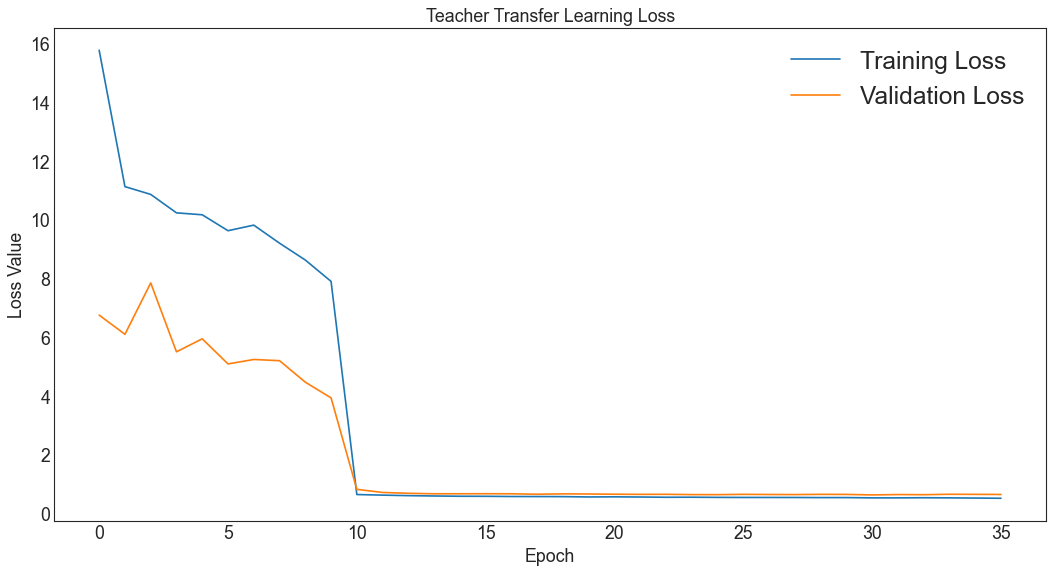

In [22]:
auc_history = metrics_history.history['auc']
val_auc_history = metrics_history.history['val_auc']

loss_history = metrics_history.history['loss']
val_loss_history = metrics_history.history['val_loss']

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(auc_history, label='Training AUC')
plt.plot(val_auc_history, label='Validation AUC')
plt.title("Teacher Transfer Learning AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.savefig("teacher_auc.svg", format="svg")

plt.clf()

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Teacher Transfer Learning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("teacher_loss.svg", format="svg")

In [13]:
# fine tune the model
for layer in resnet50v2_tf.layers:
        layer.trainable=True
print("Number of layers in the base ResNet50V2 model: ", len(resnet50.layers))  

Number of layers in the base ResNet50V2 model:  190


In [14]:
# let's fine tune only the last N layers of the model as these layers are the ones that are more specific.
# We don't need to retrain the entire model as the first layers are more general and applicable to any type of image normally
# We arbitrarily choose the Nth last layers of the original model to train (mainly limited by CPU training time)
start_fine_tuning_layer = 170
for layer in resnet50.layers[:start_fine_tuning_layer]:
  layer.trainable = False

In [15]:
resnet50v2_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_TEACHER * 0.1), # we want to reduce the learning rate to not overfit the model
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(from_logits=True)])
resnet50v2_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [16]:
metrics_history_fine_tuning = resnet50v2_tf.fit(train_set, epochs=INITIAL_EPOCHS + FINE_TUNING_EPOCHS, initial_epoch=metrics_history.epoch[-1], validation_data=validation_set)

Epoch 10/35
68/68 [==============================] - 17s 193ms/step - loss: 0.6420 - auc_1: 0.5171 - val_loss: 0.8174 - val_auc_1: 0.4985
Epoch 11/35
68/68 [==============================] - 12s 177ms/step - loss: 0.6215 - auc_1: 0.5169 - val_loss: 0.7124 - val_auc_1: 0.4794
Epoch 12/35
68/68 [==============================] - 12s 181ms/step - loss: 0.6041 - auc_1: 0.5518 - val_loss: 0.6831 - val_auc_1: 0.4843
Epoch 13/35
68/68 [==============================] - 12s 177ms/step - loss: 0.5924 - auc_1: 0.6009 - val_loss: 0.6668 - val_auc_1: 0.5547
Epoch 14/35
68/68 [==============================] - 12s 177ms/step - loss: 0.5836 - auc_1: 0.6318 - val_loss: 0.6676 - val_auc_1: 0.5970
Epoch 15/35
68/68 [==============================] - 12s 177ms/step - loss: 0.5815 - auc_1: 0.6288 - val_loss: 0.6694 - val_auc_1: 0.6197
Epoch 16/35
68/68 [==============================] - 12s 177ms/step - loss: 0.5746 - auc_1: 0.6509 - val_loss: 0.6668 - val_auc_1: 0.6323
Epoch 17/35
68/68 [===============

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\2141247984.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


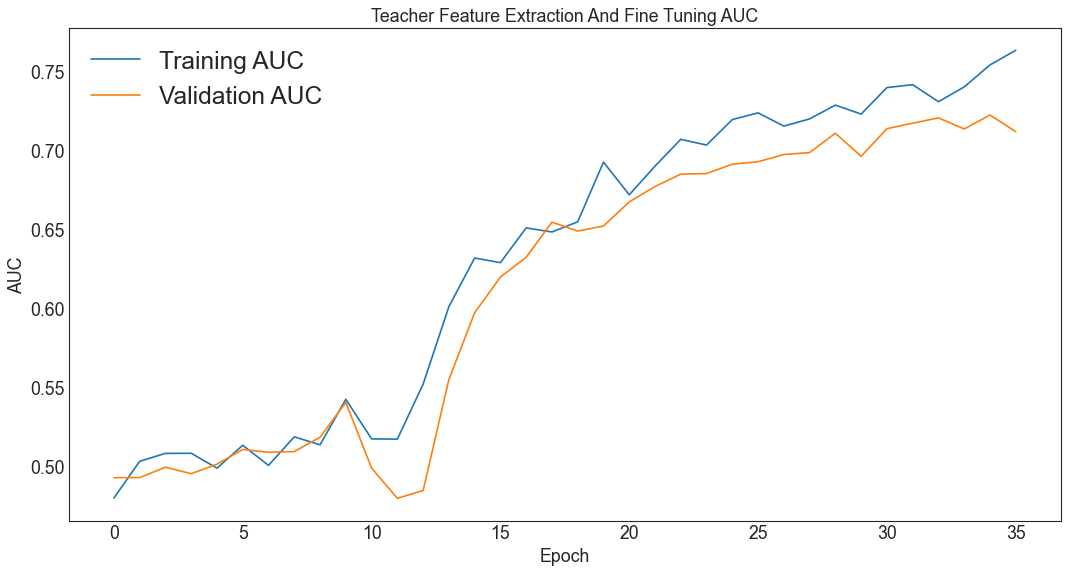

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\2141247984.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

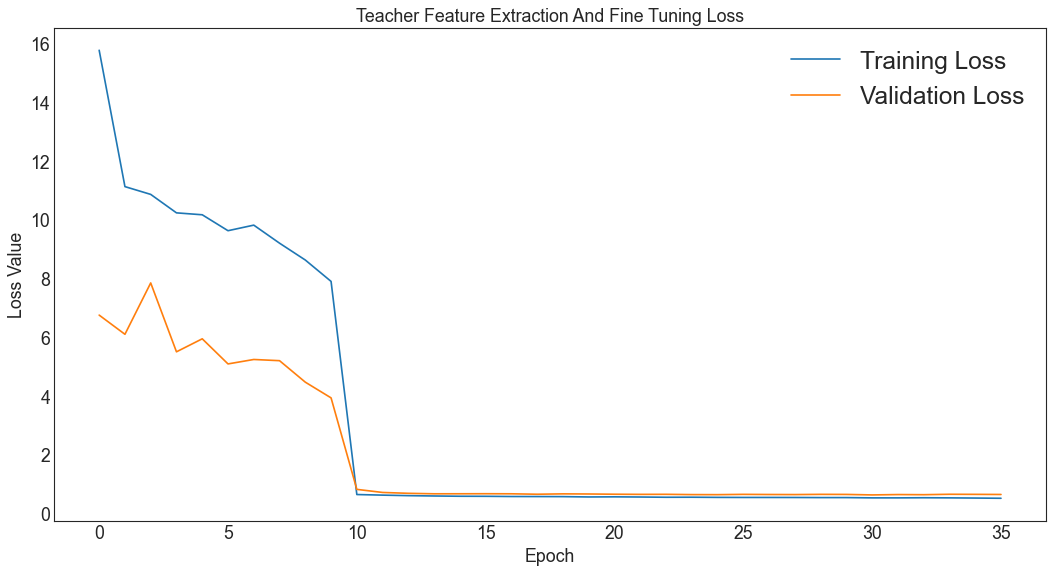

In [17]:
auc_history += metrics_history_fine_tuning.history['auc_1']
val_auc_history += metrics_history_fine_tuning.history['val_auc_1']

loss_history += metrics_history_fine_tuning.history['loss']
val_loss_history += metrics_history_fine_tuning.history['val_loss']

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(auc_history, label='Training AUC')
plt.plot(val_auc_history, label='Validation AUC')
plt.title("Teacher Feature Extraction And Fine Tuning AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.savefig("teacher_auc_fine_tuning.svg", format="svg")
plt.show()

plt.clf()

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Teacher Feature Extraction And Fine Tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("teacher_loss_fine_tuning.svg", format="svg")
plt.show()

In [32]:
mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(
                input_shape=IMAGE_TENSOR_SHAPE,
                include_top=False,
                weights='imagenet')

# make the model not trainable, since we don't want to train the pretrained model right now, 
# we only want to train the classification head we'll add on top of the model for feature extraction
for layer in mobilenetv2.layers:
        layer.trainable=False
print(mobilenetv2.summary())

student_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

student_average_layer = tf.keras.layers.GlobalAveragePooling2D()
student_dropout_layer = tf.keras.layers.Dropout(0.2)
student_prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=IMAGE_TENSOR_SHAPE)
x = data_augmentation(inputs)
x = student_preprocess_input(x)
x = mobilenetv2(x, training=False)
x = student_average_layer(x)
x = student_dropout_layer(x)
outputs = student_prediction_layer(x)
mobilenetv2_tf = tf.keras.Model(inputs, outputs)

mobilenetv2_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STUDENT),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

print("--------------------------------------------------------")
print(mobilenetv2_tf.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [33]:
student_history = mobilenetv2_tf.fit(train_dataset, epochs=INITIAL_EPOCHS, validation_data=validation_dataset)

Epoch 1/10
68/68 [==============================] - 12s 130ms/step - loss: 0.5354 - auc_4: 0.7357 - val_loss: 0.4842 - val_auc_4: 0.8300
Epoch 2/10
68/68 [==============================] - 8s 119ms/step - loss: 0.4349 - auc_4: 0.8412 - val_loss: 0.4631 - val_auc_4: 0.8493
Epoch 3/10
68/68 [==============================] - 8s 118ms/step - loss: 0.4145 - auc_4: 0.8602 - val_loss: 0.4590 - val_auc_4: 0.8578
Epoch 4/10
68/68 [==============================] - 8s 118ms/step - loss: 0.3974 - auc_4: 0.8724 - val_loss: 0.4643 - val_auc_4: 0.8586
Epoch 5/10
68/68 [==============================] - 8s 118ms/step - loss: 0.3940 - auc_4: 0.8743 - val_loss: 0.4676 - val_auc_4: 0.8616
Epoch 6/10
68/68 [==============================] - 8s 118ms/step - loss: 0.3858 - auc_4: 0.8807 - val_loss: 0.4488 - val_auc_4: 0.8616
Epoch 7/10
68/68 [==============================] - 8s 118ms/step - loss: 0.3751 - auc_4: 0.8860 - val_loss: 0.4423 - val_auc_4: 0.8667
Epoch 8/10
68/68 [=============================

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\577085130.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\577085130.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

<Figure size 1280x640 with 0 Axes>

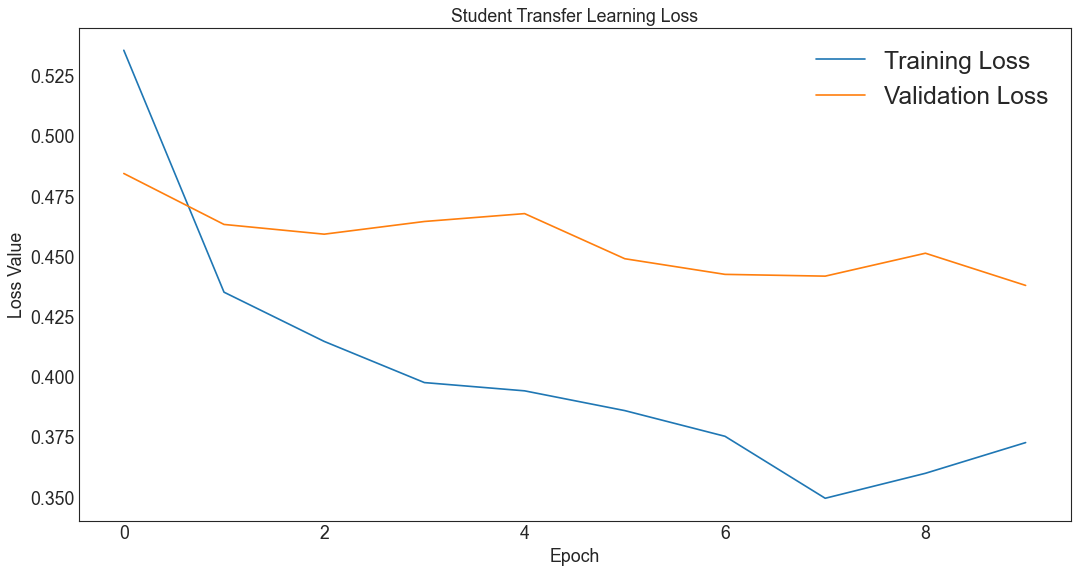

In [34]:
student_scratch_auc_history = student_history.history['auc_4']
student_scratch_val_auc_history = student_history.history['val_auc_4']

student_scratch_loss_history = student_history.history['loss']
student_scratch_val_loss_history = student_history.history['val_loss']

plt.clf()

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_scratch_auc_history, label='Training AUC')
plt.plot(student_scratch_val_auc_history, label='Validation AUC')
plt.title("Student Transfer Learning AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.savefig("student_scratch_auc.svg", format="svg")

plt.clf()

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_scratch_loss_history, label='Training Loss')
plt.plot(student_scratch_val_loss_history, label='Validation Loss')
plt.title("Student Transfer Learning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("student_scratch_loss.svg", format="svg")

In [35]:
# fine tune the model
for layer in mobilenetv2_tf.layers:
        layer.trainable=True
print("Number of layers in the base MobileNetV2 model: ", len(mobilenetv2.layers))  

Number of layers in the base MobileNetV2 model:  154


In [36]:
# let's fine tune only the last N layers of the model as these layers are the ones that are more specific.
# We don't need to retrain the entire model as the first layers are more general and applicable to any type of image normally
# We arbitrarily choose the Nth last layers of the original model to train (mainly limited by CPU training time)
start_fine_tuning_layer = 130
for layer in mobilenetv2.layers[:start_fine_tuning_layer]:
  layer.trainable = False

mobilenetv2_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STUDENT * 0.1), # we want to reduce the learning rate to not overfit the model
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(from_logits=True)])
mobilenetv2_tf.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [37]:
student_history_fine_tuning = mobilenetv2_tf.fit(train_set, epochs=INITIAL_EPOCHS + FINE_TUNING_EPOCHS, initial_epoch=student_history.epoch[-1], validation_data=validation_set)

Epoch 10/35
68/68 [==============================] - 13s 136ms/step - loss: 0.4378 - auc_5: 0.8452 - val_loss: 0.4233 - val_auc_5: 0.8769
Epoch 11/35
68/68 [==============================] - 9s 125ms/step - loss: 0.3932 - auc_5: 0.8757 - val_loss: 0.5011 - val_auc_5: 0.8742
Epoch 12/35
68/68 [==============================] - 9s 124ms/step - loss: 0.3691 - auc_5: 0.8903 - val_loss: 0.4022 - val_auc_5: 0.8963
Epoch 13/35
68/68 [==============================] - 9s 124ms/step - loss: 0.3314 - auc_5: 0.9138 - val_loss: 0.4259 - val_auc_5: 0.8912
Epoch 14/35
68/68 [==============================] - 9s 125ms/step - loss: 0.3095 - auc_5: 0.9268 - val_loss: 0.4216 - val_auc_5: 0.8891
Epoch 15/35
68/68 [==============================] - 9s 125ms/step - loss: 0.2964 - auc_5: 0.9321 - val_loss: 0.3891 - val_auc_5: 0.9055
Epoch 16/35
68/68 [==============================] - 9s 124ms/step - loss: 0.3089 - auc_5: 0.9251 - val_loss: 0.4064 - val_auc_5: 0.8985
Epoch 17/35
68/68 [=====================

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\1224131778.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

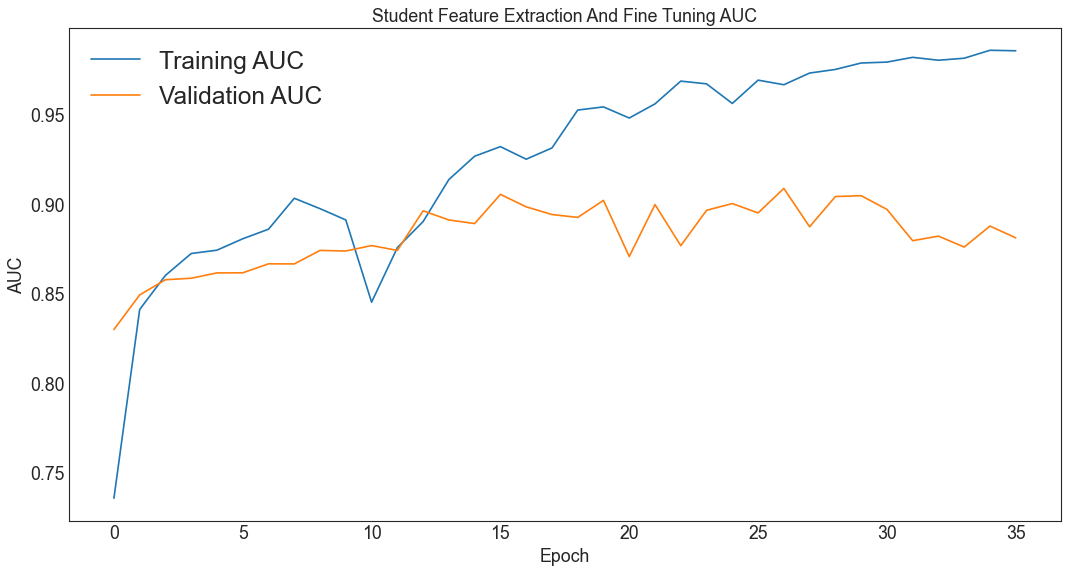

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\1224131778.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

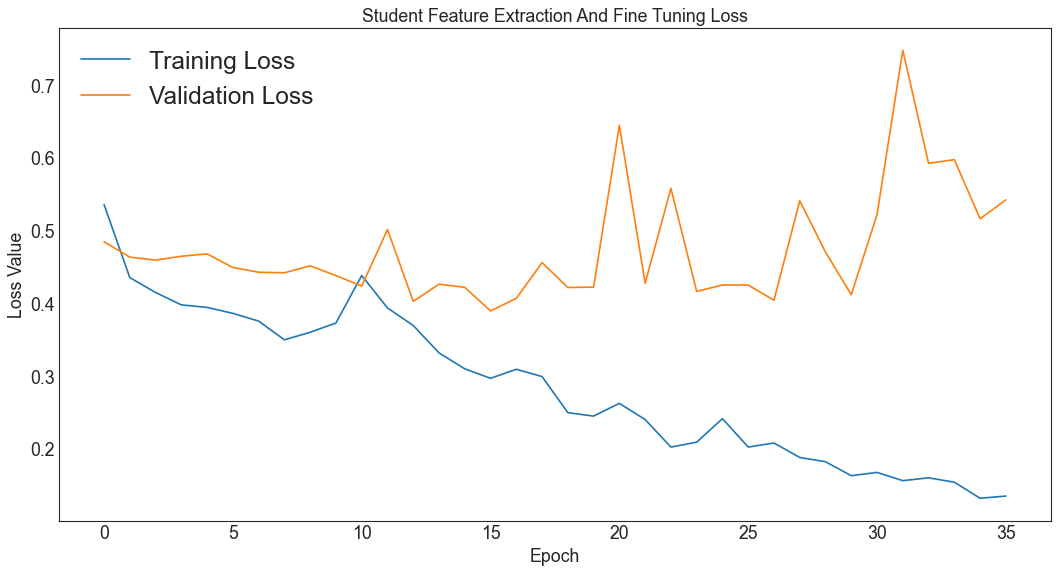

In [38]:
student_scratch_auc_history += student_history_fine_tuning.history['auc_5']
student_scratch_val_auc_history += student_history_fine_tuning.history['val_auc_5']

student_scratch_loss_history += student_history_fine_tuning.history['loss']
student_scratch_val_loss_history += student_history_fine_tuning.history['val_loss']

plt.clf()

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_scratch_auc_history, label='Training AUC')
plt.plot(student_scratch_val_auc_history, label='Validation AUC')
plt.title("Student Feature Extraction And Fine Tuning AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.savefig("student_scratch_auc_fine_tuning.svg", format="svg")
plt.show()

plt.clf()

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_scratch_loss_history, label='Training Loss')
plt.plot(student_scratch_val_loss_history, label='Validation Loss')
plt.title("Student Feature Extraction And Fine Tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("student_scratch_loss_fine_tuning.svg", format="svg")
plt.show()

In [44]:
mobilenetv2kd = tf.keras.applications.mobilenet_v2.MobileNetV2(
                input_shape=IMAGE_TENSOR_SHAPE,
                include_top=False,
                weights='imagenet')

# make the model not trainable, since we don't want to train the pretrained model right now, 
# we only want to train the classification head we'll add on top of the model for feature extraction
for layer in mobilenetv2kd.layers:
        layer.trainable=False
print(mobilenetv2kd.summary())

student_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

student_average_layer = tf.keras.layers.GlobalAveragePooling2D()
student_dropout_layer = tf.keras.layers.Dropout(0.2)
student_prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=IMAGE_TENSOR_SHAPE)
x = data_augmentation(inputs)
x = student_preprocess_input(x)
x = mobilenetv2kd(x, training=False)
x = student_average_layer(x)
x = student_dropout_layer(x)
outputs = student_prediction_layer(x)
mobilenetv2kd_tf = tf.keras.Model(inputs, outputs, name="student")

print("--------------------------------------------------------")
print(mobilenetv2kd_tf.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [56]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """

  return tf.reduce_mean(tf.keras.losses.binary_crossentropy(teacher_logits, student_logits))

In [57]:
# Reference: distiller class implemented from the official keras.io documentation website: https://keras.io/examples/vision/knowledge_distillation/
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=32,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        print(str(teacher_predictions))

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = self.distillation_loss_fn(teacher_predictions / self.temperature, student_predictions / self.temperature) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [62]:
teacher = resnet50v2_tf
student = mobilenetv2kd_tf

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_KD),
                    metrics=[tf.keras.metrics.AUC(from_logits=True)],
                    student_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    distillation_loss_fn=distillation_loss,
                    alpha=0.5,
                    temperature=32)

In [63]:
# Distill teacher to student
student_kd_history = distiller.fit(train_dataset, epochs=INITIAL_EPOCHS, validation_data=validation_dataset)

Epoch 1/10
Tensor("model/dense/BiasAdd:0", shape=(None, 1), dtype=float32)
Tensor("model/dense/BiasAdd:0", shape=(None, 1), dtype=float32)
68/68 [==============================] - 18s 197ms/step - auc_10: 0.7425 - student_loss: 0.6229 - distillation_loss: 209.4429 - val_auc_10: 0.7141 - val_student_loss: 0.6975
Epoch 2/10
68/68 [==============================] - 13s 189ms/step - auc_10: 0.7522 - student_loss: 0.5966 - distillation_loss: 201.9099 - val_auc_10: 0.7652 - val_student_loss: 0.5770
Epoch 3/10
68/68 [==============================] - 13s 189ms/step - auc_10: 0.7580 - student_loss: 0.5810 - distillation_loss: 197.4915 - val_auc_10: 0.7382 - val_student_loss: 0.5275
Epoch 4/10
68/68 [==============================] - 13s 188ms/step - auc_10: 0.7086 - student_loss: 0.7072 - distillation_loss: 198.0872 - val_auc_10: 0.7424 - val_student_loss: 0.3593
Epoch 5/10
68/68 [==============================] - 13s 190ms/step - auc_10: 0.6891 - student_loss: 0.6446 - distillation_loss: 199.

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\3383577311.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\3383577311.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

<Figure size 1280x640 with 0 Axes>

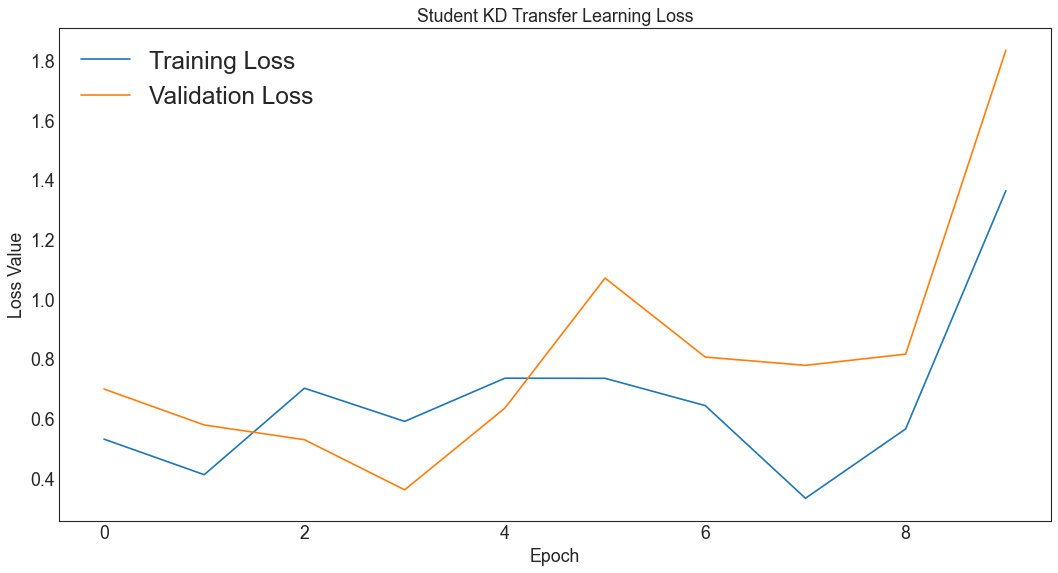

In [64]:
student_kd_auc_history = student_kd_history.history['auc_10']
student_kd_val_auc_history = student_kd_history.history['val_auc_10']

student_kd_loss_history = student_kd_history.history['student_loss']
student_kd_val_loss_history = student_kd_history.history['val_student_loss']

plt.clf()

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_kd_auc_history, label='Training AUC')
plt.plot(student_kd_val_auc_history, label='Validation AUC')
plt.title("Student KD Transfer Learning AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.savefig("student_kd_auc.svg", format="svg")

plt.clf()

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_kd_loss_history, label='Training Loss')
plt.plot(student_kd_val_loss_history, label='Validation Loss')
plt.title("Student KD Transfer Learning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("student_kd_loss.svg", format="svg")

In [65]:
# fine tune the model
for layer in mobilenetv2kd_tf.layers:
        layer.trainable=True
print("Number of layers in the base MobileNetV2 model: ", len(mobilenetv2kd.layers))  

start_fine_tuning_layer = 130
for layer in mobilenetv2kd.layers[:start_fine_tuning_layer]:
  layer.trainable = False

mobilenetv2kd_tf.summary()

Number of layers in the base MobileNetV2 model:  154
Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
      

In [66]:
teacher = resnet50v2_tf
student = mobilenetv2kd_tf

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_KD * 0.1),
                    metrics=[tf.keras.metrics.AUC(from_logits=True)],
                    student_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    distillation_loss_fn=distillation_loss,
                    alpha=0.5,
                    temperature=32)

In [67]:
student_kd_history_fine_tuning = distiller.fit(train_set, epochs=INITIAL_EPOCHS + FINE_TUNING_EPOCHS, initial_epoch=student_kd_history.epoch[-1], validation_data=validation_set)

Epoch 10/35
Tensor("model/dense/BiasAdd:0", shape=(None, 1), dtype=float32)
Tensor("model/dense/BiasAdd:0", shape=(None, 1), dtype=float32)
68/68 [==============================] - 19s 205ms/step - auc_11: 0.6220 - student_loss: 0.6478 - distillation_loss: 194.2552 - val_auc_11: 0.7718 - val_student_loss: 0.5151
Epoch 11/35
68/68 [==============================] - 13s 193ms/step - auc_11: 0.7534 - student_loss: 0.5454 - distillation_loss: 174.2213 - val_auc_11: 0.7783 - val_student_loss: 0.8239
Epoch 12/35
68/68 [==============================] - 13s 194ms/step - auc_11: 0.7808 - student_loss: 0.5329 - distillation_loss: 172.4356 - val_auc_11: 0.7805 - val_student_loss: 0.5289
Epoch 13/35
68/68 [==============================] - 13s 194ms/step - auc_11: 0.7792 - student_loss: 0.5303 - distillation_loss: 171.8177 - val_auc_11: 0.7879 - val_student_loss: 0.5637
Epoch 14/35
68/68 [==============================] - 13s 193ms/step - auc_11: 0.7545 - student_loss: 0.5420 - distillation_loss:

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\1457664675.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

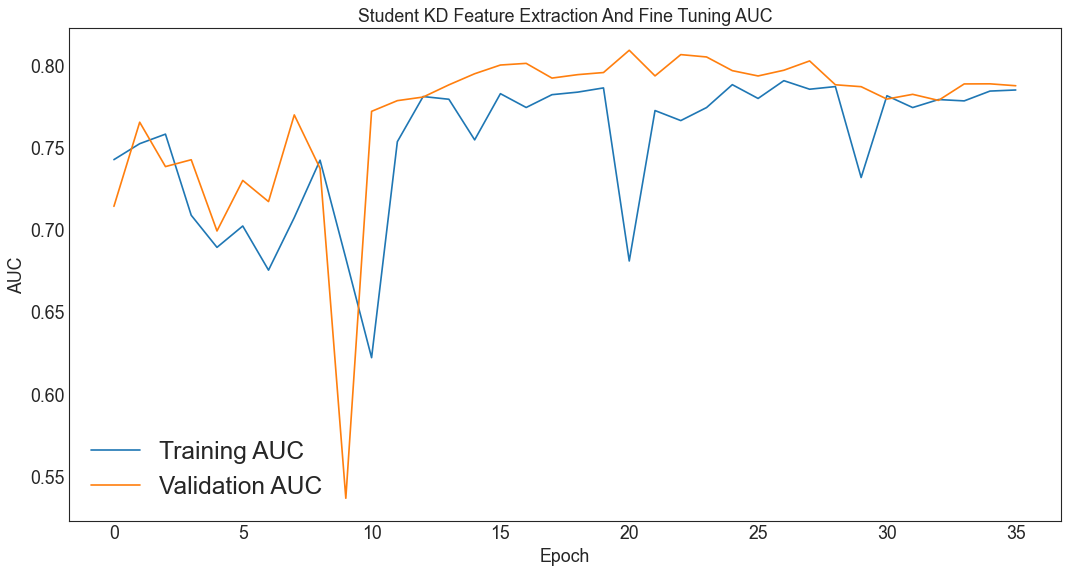

C:\Users\etsms\AppData\Local\Temp\ipykernel_26476\1457664675.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1600x1000 with 0 Axes>

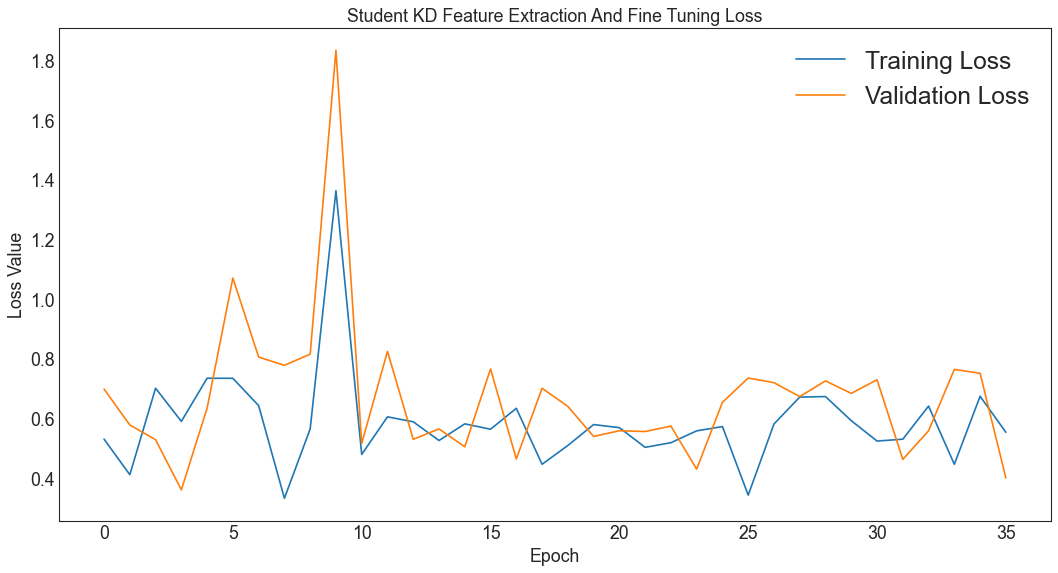

In [68]:
student_kd_auc_history += student_kd_history_fine_tuning.history['auc_11']
student_kd_val_auc_history += student_kd_history_fine_tuning.history['val_auc_11']

student_kd_loss_history += student_kd_history_fine_tuning.history['student_loss']
student_kd_val_loss_history += student_kd_history_fine_tuning.history['val_student_loss']

plt.clf()

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_kd_auc_history, label='Training AUC')
plt.plot(student_kd_val_auc_history, label='Validation AUC')
plt.title("Student KD Feature Extraction And Fine Tuning AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.savefig("student_kd_auc_fine_tuning.svg", format="svg")
plt.show()

plt.clf()

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

plt.plot(student_kd_loss_history, label='Training Loss')
plt.plot(student_kd_val_loss_history, label='Validation Loss')
plt.title("Student KD Feature Extraction And Fine Tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.savefig("student_kd_loss_fine_tuning.svg", format="svg")
plt.show()